In [62]:
import random
from math import sqrt
from datetime import datetime, timedelta

from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
%config InlineBackend.figure_formats = ['svg']

import shap

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

## Seeds

In [4]:
# fixing seeds

SEED = 0xCAFEC0DE
random.seed(SEED)
np.random.seed(SEED)

In [5]:
TRAIN_PATH = 'data/train.csv'

## Data loading

In [6]:
train = pd.read_csv(TRAIN_PATH)

In [7]:
# time features

In [8]:
train['datetime'] = train['datetime'].apply(lambda x: pd.to_datetime(x))

In [9]:
def create_time_features(df):
    df['year'] = df['datetime'].apply(lambda x: x.year)
    df['day'] = df['datetime'].apply(lambda x: x.day)
    df['quarter'] = df['datetime'].apply(lambda x: x.quarter)
    df['month'] = df['datetime'].apply(lambda x: x.month)
    df['week'] = df['datetime'].apply(lambda x: x.week)
    
    df['day_of_year'] = df['datetime'].apply(lambda x: x.day_of_year)
    df['day_of_week'] = df['datetime'].apply(lambda x: x.day_of_week)
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if 5 <= x <= 6 else 0)
    
    months_in_year = 30
    df['month_sin'] = np.sin(2*np.pi*df.month/months_in_year)
    df['month_cos'] = np.cos(2*np.pi*df.month/months_in_year)
    
    days_in_month = 30
    df['day_sin'] = np.sin(2*np.pi*df.day/days_in_month)
    df['day_cos'] = np.cos(2*np.pi*df.day/days_in_month)
    
    days_in_week = 7
    df['day_week_sin'] = np.sin(2*np.pi*df.day_of_week/days_in_month)
    df['day_week_cos'] = np.cos(2*np.pi*df.day_of_week/days_in_month)

    days_in_year = 365
    df['day_of_year_sin'] = np.sin(2*np.pi*df.day_of_year/days_in_year)
    df['day_of_year_cos'] = np.cos(2*np.pi*df.day_of_year/days_in_year)

    weeks_in_year = 52.1429
    df['week_of_year_sin'] = np.sin(2*np.pi*df.week/weeks_in_year)
    df['week_of_year_cos'] = np.cos(2*np.pi*df.week/weeks_in_year)

    quarters_in_year = 4
    df['quarter_sin'] = np.sin(2*np.pi*df.quarter/quarters_in_year)
    df['quarter_cos'] = np.cos(2*np.pi*df.quarter/quarters_in_year)

In [10]:
create_time_features(train)

In [11]:
def plot_feature_for_ts(df, ts_num, feature):
    plt.figure(figsize=(10, 5))
    tmp = df[df['Номер скважины'] == ts_num]
    plt.plot(tmp['datetime'], tmp[feature])
    plt.grid()
    plt.title(f"{feature} скважины {ts_num}", size=14)
    plt.show()

In [13]:
# filling nans in timeseries

In [14]:
def fill_feature_ts(feature):
    
    for i in train['Номер скважины'].unique():
        
        train.loc[
            train['Номер скважины'] == i, 
            feature
        ] = train[train['Номер скважины'] == i][feature].interpolate(method='linear')
        
        tmp = train.loc[
            train['Номер скважины'] == i, 
            feature
        ].to_numpy()


        train.loc[
            (train[feature].isnull())
            & (train['Номер скважины'] == i), 
            feature
        ] = tmp[~np.isnan(tmp)][0]

In [22]:
train.isnull().sum().sort_values(ascending=False).head(15)

Объем жидкости                 63671
Объем нефти                    63671
Давление буферное              56928
Газовый фактор рабочий (ТМ)    41906
Дебит газа (ТМ)                34005
Давление забойное от Pпр       24839
Дебит газа попутного           15767
Давление на входе ЭЦН (ТМ)      9056
Дебит жидкости (ТМ)             7929
Активная мощность (ТМ)          4724
Время работы (ТМ)               3661
Коэффициент мощности (ТМ)       2986
Давление забойное               2380
Давление забойное от Hд         1426
Давление линейное (ТМ)           340
dtype: int64

In [23]:
# features with not much misses - filling them with linear interploation
features = [
    'Давление линейное (ТМ)',
    'Время работы (ТМ)',
    'Давление забойное',
    'Коэффициент мощности (ТМ)',
    'Активная мощность (ТМ)',
    'Давление на входе ЭЦН (ТМ)',
    'Давление забойное от Hд',
    'Дебит жидкости (ТМ)',
    'Дебит газа попутного'
]

In [24]:
for feature in features:
    fill_feature_ts(feature)

In [25]:
# features with much misses - filling them with mean or zero
misses = train.isnull().sum()
missing_cols = misses[misses > 0].index.tolist()
missing_cols

['Объем жидкости',
 'Объем нефти',
 'Газовый фактор рабочий (ТМ)',
 'Давление буферное',
 'Давление забойное от Pпр',
 'Дебит газа (ТМ)']

In [26]:
for feature in missing_cols:
    for ts_num in train['Номер скважины'].unique():
        feature_mean = train[train['Номер скважины'] == ts_num][feature].to_numpy()
        feature_mean = feature_mean[~np.isnan(feature_mean)]
        if feature_mean.shape[0] == 0:
            feature_mean = 0
        else:
            feature_mean = feature_mean.mean()
        train.loc[train['Номер скважины'] == ts_num, feature] = feature_mean

## Making lags

In [27]:
# create lags of target for each hole
def concat_shifts(df, i, n_days=10):
    tmp = df[df['Номер скважины'] == i].reset_index(drop=True).copy()
    data = np.array([tmp['Дебит нефти'].shift(periods=(i + 1)).values for i in range(n_days)]).T
    shifted_df = pd.DataFrame(data, columns=[f"скважина_шифт_{i + 1}"for i in range(n_days)]).copy()
    return pd.concat([tmp, shifted_df], axis=1).iloc[n_days:].reset_index(drop=True)

In [28]:
# this parameter was chosen on validation
n_days = 11
df = pd.concat([
    concat_shifts(train, i, n_days=n_days) 
    for i in train['Номер скважины'].unique()
], axis=0)

## Create dataframe for prediction

In [29]:
ts_features = []
for ts_num in train['Номер скважины'].unique():
    cur_df = pd.DataFrame()
    for feature in features:
        pred = train[train['Номер скважины'] == ts_num][feature].values[-200:].mean()
        cur_df[feature] = [pred]
        
    for feature in missing_cols:
        pred = train[train['Номер скважины'] == ts_num][feature].mean()
        cur_df[feature] = [pred]
    
    for feature in ['x', 'y']:
        pred = train[train['Номер скважины'] == ts_num][feature].mean()
        cur_df[feature] = [pred]
    
    cur_df['Номер скважины'] = ts_num
    ts_features.append(cur_df)

In [32]:
PREDICTION_START = '1992-04-12'
PREDICTION_END = '1992-07-10'

dataframes = []

for ts_num in train['Номер скважины'].unique():
    ts_max_date = train[train['Номер скважины'] == ts_num]['datetime'].max().strftime('%Y-%m-%d')
    ts_max_date = (datetime.strptime(ts_max_date, "%Y-%m-%d") + timedelta(days=1)).strftime('%Y-%m-%d')
    if ts_max_date <= PREDICTION_START:
        ts_max_date = PREDICTION_START
    date_range = pd.date_range(start=ts_max_date, end=PREDICTION_END, freq='1D').tolist()
    num = [ts_num] * len(date_range)
    dataframes.append(pd.DataFrame(np.array([date_range, num]).T, columns=['datetime', 'Номер скважины']))

In [33]:
X_submit = pd.concat(dataframes, axis=0).reset_index(drop=True)
X_submit = X_submit.merge(
    pd.concat(ts_features, axis=0).reset_index(drop=True), 
    on='Номер скважины', 
    how='left'
)
X_submit[[f"скважина_шифт_{i + 1}" for i in range(n_days)]] = 0
create_time_features(X_submit)
X_submit = X_submit[df.drop(columns=['Дебит нефти']).columns.tolist()]

## Training and train-test split

In [37]:
test_date = pd.to_datetime('1992-02-01')

In [38]:
# for catboost
cat_features = [
     'Номер скважины', 
     'year',
     'day',
     'quarter',
     'month',
     'week',
     'day_of_year',
     'day_of_week',
     'is_weekend'
]

In [39]:
df[cat_features] = df[cat_features].astype(int)
X_submit[cat_features] = X_submit[cat_features].astype(int)

In [40]:
test_date = pd.to_datetime('1992-02-01')

_train = df[df['datetime'] <= test_date].reset_index(drop=True)
_test = df[df['datetime'] > test_date].reset_index(drop=True)
X_train, y_train = _train.drop(columns=['datetime', 'Дебит нефти']), _train['Дебит нефти']
X_test, y_test = _test.drop(columns=['datetime', 'Дебит нефти']), _test['Дебит нефти']

In [41]:
cb_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'cat_features': cat_features,
    'verbose': 200,
    'random_seed': SEED,
    'border_count': 128,
    'iterations': 2000,
}

In [42]:
cb = CatBoostRegressor(**cb_params)
cb.fit(X_train, y_train)

Learning rate set to 0.044289
0:	learn: 8.6940758	total: 81.4ms	remaining: 2m 42s
200:	learn: 1.0458958	total: 4.01s	remaining: 35.9s
400:	learn: 0.9068934	total: 8.54s	remaining: 34.1s
600:	learn: 0.8302407	total: 13.3s	remaining: 30.8s
800:	learn: 0.7812601	total: 17.7s	remaining: 26.5s
1000:	learn: 0.7394998	total: 22.3s	remaining: 22.3s
1200:	learn: 0.7102580	total: 26.6s	remaining: 17.7s
1400:	learn: 0.6845285	total: 31s	remaining: 13.3s
1600:	learn: 0.6654647	total: 35.3s	remaining: 8.8s
1800:	learn: 0.6464406	total: 39.8s	remaining: 4.4s
1999:	learn: 0.6291972	total: 44.4s	remaining: 0us


In [44]:
xgb_params = {
    'n_estimators': 1000,
    'max_depth': 7,
    'eta': 0.1,
    'subsample': 0.7,
    'colsample_bytree': 0.8,
    'random_state': SEED
}

In [45]:
xgb = XGBRegressor(**xgb_params)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=3405693150, reg_alpha=0, ...)

## Metrics

In [46]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

## Validation estimation

In [48]:
def make_prediction(model, X_train, y_train, X_test, ts_num):
    y_train = y_train.loc[X_train[X_train['Номер скважины'] == ts_num].index.tolist()]
    X_test = X_test[X_test['Номер скважины'] == ts_num].reset_index(drop=True)
    predictions = y_train.iloc[-n_days:].tolist()
    for i in range(X_test.shape[0]):
        cur_row = pd.DataFrame(X_test.iloc[i].tolist()[:-n_days] + predictions[-n_days:][::-1]).T
        cur_row.columns = X_test.columns
        cur_row[cat_features] = cur_row[cat_features].astype(int)
        cur_pred = model.predict(cur_row).item()
        predictions.append(cur_pred)
    return predictions[n_days:]

In [49]:
y_cb_pred = []
y_xgb_pred = []
for ts_num in tqdm(df['Номер скважины'].unique()):
    current_predictions = make_prediction(cb, X_train, y_train, X_test, ts_num)
    y_cb_pred.append(current_predictions)
    current_predictions = make_prediction(xgb, X_train, y_train, X_test, ts_num)
    y_xgb_pred.append(current_predictions)

100%|██████████| 106/106 [02:31<00:00,  1.43s/it]


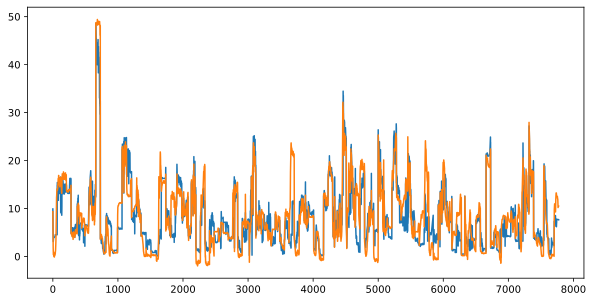

In [52]:
# flatten prediction of catboost
plt.figure(figsize=(10, 5))
plt.plot(y_test)
plt.plot(np.hstack(y_cb_pred));

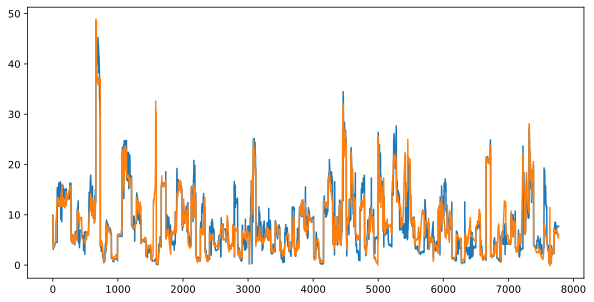

In [53]:
# flatten prediction of xgboost
plt.figure(figsize=(10, 5))
plt.plot(y_test)
plt.plot(np.hstack(y_xgb_pred));

In [60]:
print(f"CatBoost validation RMSE: {rmse(y_test,np.hstack(y_cb_pred)):.4f}")
print(f"XGBoost validation RMSE: {rmse(y_test,np.hstack(y_xgb_pred)):.4f}")

CatBoost validation RMSE: 3.7605
XGBoost validation RMSE: 2.9120


In [59]:
# was used for choosing n_days parameter for lag

# for n_days in tqdm(range(2, 20)):
#     df = pd.concat([concat_shifts(train, i, n_days=n_days) for i in train['Номер скважины'].unique()], axis=0)

#     df[cat_features] = df[cat_features].astype(int)

#     test_date = pd.to_datetime('1992-02-01')

#     _train = df[df['datetime'] <= test_date].reset_index(drop=True)
#     _test = df[df['datetime'] > test_date].reset_index(drop=True)
#     X_train, y_train = _train.drop(columns=['datetime', 'Дебит нефти']), _train['Дебит нефти']
#     X_test, y_test = _test.drop(columns=['datetime', 'Дебит нефти']), _test['Дебит нефти']

#     # cb = CatBoostRegressor(**cb_params)
#     # cb.fit(X_train, y_train, verbose=0)
#     xgb = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, 
#                        colsample_bytree=0.8, random_state=SEED)
#     xgb.fit(X_train, y_train)
#     y_test_pred = []
#     for ts_num in df['Номер скважины'].unique():
#         current_predictions = make_prediction(xgb, X_train, y_train, X_test, ts_num)
#         y_test_pred.append(current_predictions)

#     print(f"On n_days={n_days} RMSE: {rmse(y_test,np.hstack(y_test_pred)):.6f}")

## Feature selection with LASSO

In [63]:
sel_ = SelectFromModel(Lasso(alpha=10, random_state=SEED))
sel_.fit(X_train, y_train)
selected_cols = ['Номер скважины'] + X_train.columns[sel_.get_support().tolist()].tolist()

In [64]:
xgb = XGBRegressor(**xgb_params)
xgb.fit(X_train.loc[:, selected_cols], y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=3405693150, reg_alpha=0, ...)

In [66]:
# reassign function to predict there properly
def make_prediction(model, X_train, y_train, X_test, ts_num, n_days=1):
    y_train = y_train.loc[X_train[X_train['Номер скважины'] == ts_num].index.tolist()]
    X_test = X_test[X_test['Номер скважины'] == ts_num].reset_index(drop=True)
    predictions = y_train.iloc[-n_days:].tolist()
    for i in range(X_test.shape[0]):
        cur_row = pd.DataFrame(X_test.iloc[i].tolist()[:-n_days] + predictions[-n_days:][::-1]).T
        cur_row.columns = X_test.columns
        # cur_row[cat_features] = cur_row[cat_features].astype(int)
        cur_pred = model.predict(cur_row).item()
        predictions.append(cur_pred)
    return predictions[n_days:]

In [67]:
y_test_pred = []
for ts_num in df['Номер скважины'].unique():
    current_predictions = make_prediction(
        xgb, 
        X_train.loc[:, selected_cols],
        y_train, 
        X_test.loc[:, selected_cols], 
        ts_num
    )
    y_test_pred.append(current_predictions)

In [69]:
rmse(y_test,np.hstack(y_test_pred))

2.642976800928094

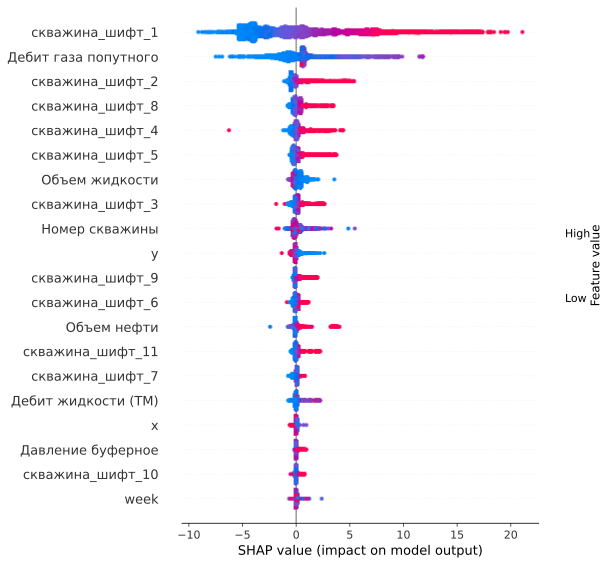

In [70]:
explainer = shap.TreeExplainer(cb)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

## Evaluation on test

In [80]:
def make_prediction(model, X_train, y_train, X_test, ts_num):
    y_train = y_train.loc[X_train[X_train['Номер скважины'] == ts_num].index.tolist()]
    X_test = X_test[X_test['Номер скважины'] == ts_num].reset_index(drop=True)
    predictions = y_train.iloc[-n_days:].tolist()
    for i in range(X_test.shape[0]):
        cur_row = pd.DataFrame(X_test.iloc[i].tolist()[:-n_days] + predictions[-n_days:][::-1]).T
        cur_row.columns = X_test.columns
        cur_row[cat_features] = cur_row[cat_features].astype(int)
        cur_pred = model.predict(cur_row).item()
        predictions.append(cur_pred)
    return predictions[n_days:]

In [74]:
_tmp = df.copy()
X, y = _tmp.drop(columns=['datetime', 'Дебит нефти']), _tmp['Дебит нефти']

In [77]:
submit_dates = X_submit['datetime']

In [78]:
X_submit.drop(columns=['datetime'], inplace=True)

In [81]:
# xgb performs better according to validation though catboost shows better submit results


# get first last n_days values of target in X to start predicting
y_submit = []
for ts_num in tqdm(df['Номер скважины'].unique()):
    current_predictions = make_prediction(cb, X, y, X_submit, ts_num)
    y_submit.append(current_predictions)

100%|██████████| 106/106 [01:24<00:00,  1.25it/s]


In [82]:
# placing predictions
X_submit['datetime'] = submit_dates

for i, ts_num in enumerate(df['Номер скважины'].unique()):
    X_submit.loc[X_submit['Номер скважины'] == ts_num, 'Дебит нефти'] = y_submit[i]

In [83]:
# renaming according to output format
columns = ['datetime', 'Дебит нефти', 'Номер скважины']
submission = X_submit[columns]

In [84]:
# some of test target was in train - lets use it
was_in_df = train[train['datetime'] >= pd.to_datetime(PREDICTION_START)][columns]
submission = pd.concat([submission, was_in_df], axis=0).sort_values(by=['Номер скважины', 'datetime']).reset_index(drop=True)

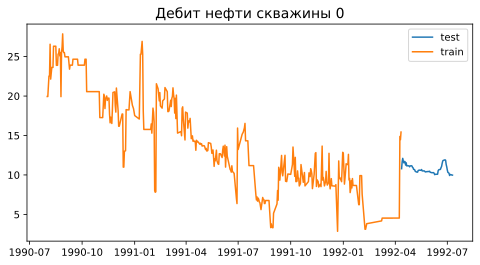

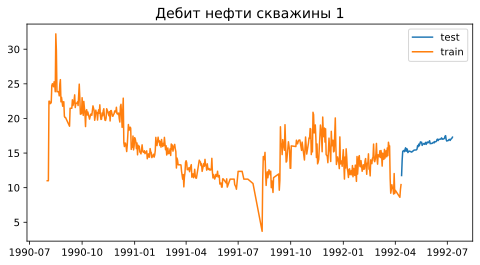

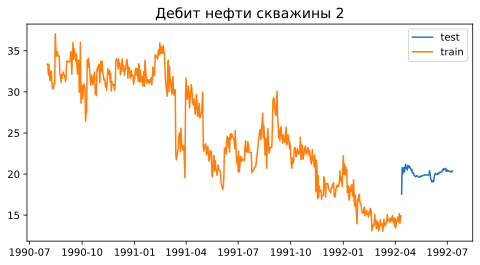

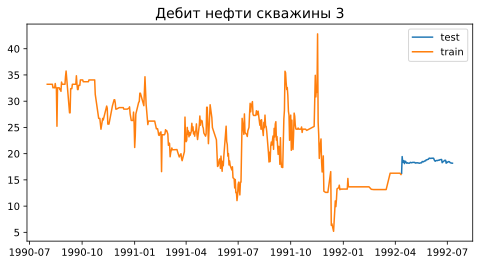

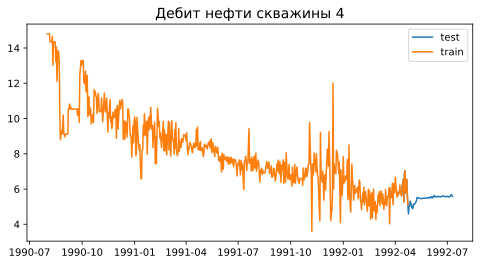

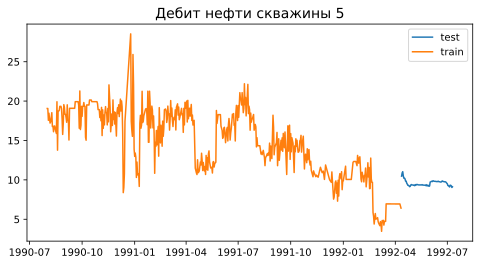

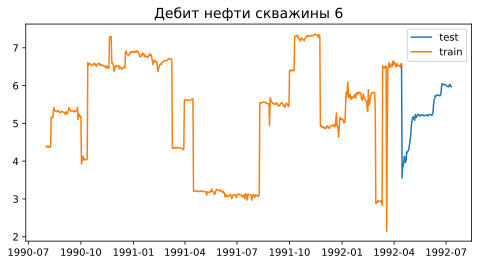

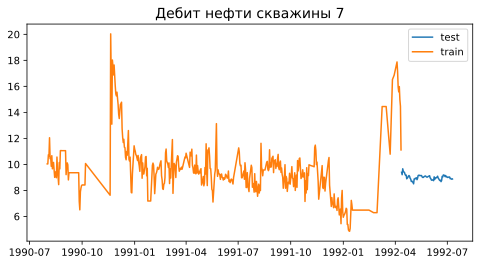

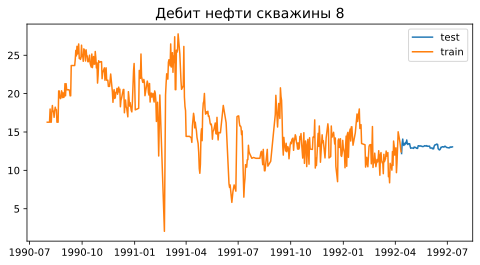

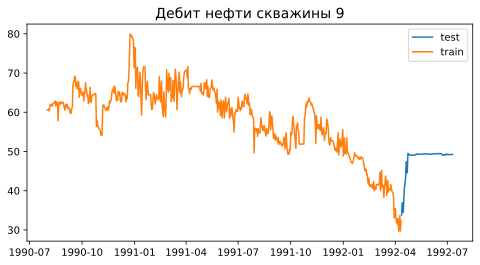

In [87]:
k_to_plot = 10
for i in range(k_to_plot):
    plt.figure(figsize=(8, 4))
    plt.plot(
        submission[submission['Номер скважины'] == i]['datetime'],
        submission[submission['Номер скважины'] == i]['Дебит нефти'],
        label='test'
    )
    plt.plot(
        train[train['Номер скважины'] == i]['datetime'],
        train[train['Номер скважины'] == i]['Дебит нефти'],
        label='train'
    )
    plt.title(f"Дебит нефти скважины {i}", size=14)
    plt.legend()
    plt.show()

In [88]:
# seems fine, lets submit

In [89]:
submission.columns = ['datetime', 'forecast', 'Номер скважины']

In [90]:
submission.to_csv('submit.csv', index=False, encoding='utf-8')